In [190]:
%matplotlib inline

from matplotlib import pyplot as plt

import numpy as np
import pandas as pd

## Theory

We assume the internal temperature of the waterheater is related to the power consumption, we can simulate the internal temperature change of the waterheater.

$$
T_{t+1} = \alpha T_{t}+(1-\alpha)(T^{amb}-m_tT^{gain}) +\epsilon_{t}
$$

where

$T_{t+1}$ is the internal temperature,

$\alpha=e^{-\frac{h}{C\cdot R}}$ and $h$ is the time step, $R$ is the resistance, $C$ is the thermal capacitance,

$T^{amb}$ is the ambient temperature,

$m_t$ is the binary status of the water heater determined by checking whether the $T_t$ is within the set point band $[T^{s}-\frac{\delta}{2},T^{s}+\frac{\delta}{2}]$,

$T^{gain}= -R\cdot P^{r}$ is the thermal gain, and $R$ is the resistance, $P^{r}$ is the rated power of the device,

$\epsilon_{t} \sim \mathcal{N}(0,\sigma)$ is the noise.

## Choose parameter values

In [218]:
# These should be decided based on the parameters from the real waterheaters

T_0 = 120. # beginning water temperature, fahrenheit

h = 1. # time step, second

C = 263. # kW/degF

R = 10. # degF/kW

T_amb = 65. # fixed ambient

m_t = 0 # start with 0, change to 1 if the temperature is below T_s-delta/2, 
        #change to 0 if the temperature is above T_s+delta/2

P_r = 8. # kW

sigma = 0.1 # noise, fluctuations of the temperature

T_s = 130. # waterheater setpoint, fahrenheit

delta = 3. # deadband

## Define simulator function

In [220]:
# we define the simulator

def simulator(duration,
              T_0=120.,
              h=1.,
              C=263.,
              R=10.,
              T_amb=65.,
              m_t=0,
              P_r=8.,
              sigma=0.1,
              T_s=130.,
              delta=3.):
    
    count = int(duration / h)
    
    T_sim = np.zeros(count)
    Ms = np.zeros(count)
    
    T_sim[0] = T_0

    alpha = np.exp(-h/(C*R))

    T_gain = -R*P_r
    print('alpha:%f, T_gain:%f' % (alpha,T_gain))

    T_t = T_0
    for i in range(count-1):
        if T_t < T_s - delta/2.:
            # turn on the waterheater
            m_t = 1
        elif T_t > T_s + delta/2.:
            # turn off the water heater
            m_t = 0
        # track the status change    
        Ms[i] = m_t
        epsilon_t = sigma * np.random.randn(1)
        T_t = alpha * T_t + (1-alpha)*(T_amb - m_t * T_gain) + epsilon_t
        T_sim[i+1] = T_t[0]

    return T_sim, (Ms,alpha,T_gain)
    

## Start simulation

In [230]:
# we simulate for one day, the time step is 1s
duration = 3600 * 24
step = 1.

T1,_ = simulator(duration, h=step)
df_sim_1day_1s = pd.DataFrame(T1,index=pd.date_range('1/1/2017',periods=duration/step,
                                                     freq=str(int(step*1000))+'ms'),columns=['temperature'])

alpha:0.999620, T_gain:-80.000000


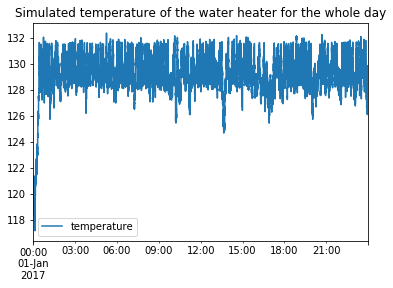

In [231]:
df_sim_1day_1s.plot(title='Simulated temperature of the water heater for the whole day')

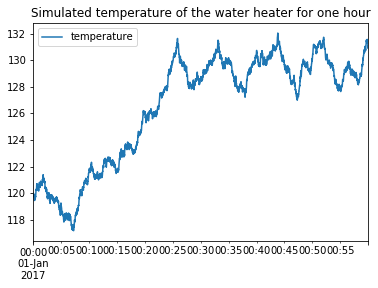

In [232]:
df_sim_1day_1s[:3600].plot(title='Simulated temperature of the water heater for one hour')

In [233]:
# We simulate for one minute, the time step is 10 ms
duration = 60
step = 0.01
sigma = 0.02 # At a higher frequency, the flcutation of the temperature should be less, we change from .1 to .02

T2,_ = simulator(duration, h=step,sigma=0.02)
df_sim_1min_10ms = pd.DataFrame(T2,index=pd.date_range('1/1/2017',periods=duration/step,
                                                     freq=str(int(step*1000))+'ms'),columns=['temperature'])

alpha:0.999996, T_gain:-80.000000


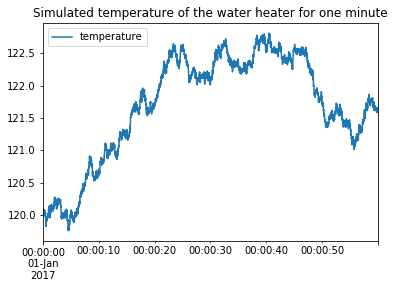

In [234]:
df_sim_1min_10ms.plot(title='Simulated temperature of the water heater for one minute')

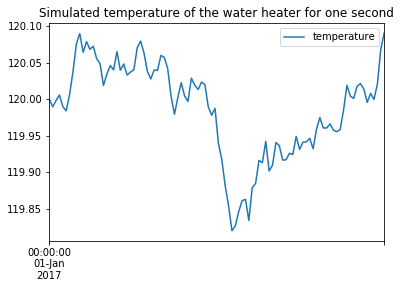

In [235]:
df_sim_1min_10ms[:100].plot(title='Simulated temperature of the water heater for one second')